In [1]:
%%time

import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations
import copy

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pickle
import gzip

import os
import imageio
import glob

from skimage.transform import resize

#Ignore warnings
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CPU times: user 2.63 s, sys: 379 ms, total: 3.01 s
Wall time: 3.03 s


In [2]:
cs_name_val = 2
meth_name_str_list = [1,2,3,4,5]
param_name_str = "y0"
normalize = False
noise_mean = 0
noise_std = 0.01
sep_fact = 1.0
retrain_GP = 1
reoptimize_obj = 5
seed = 1
num_x_data = 5
num_theta_data_scl = 5
num_theta_data_val = 0
gen_meth_theta_val = None
val_data = None
val_sse_data = None
gen_heat_map_data = True
gen_meth_x = Gen_meth_enum(1)

#Set Stuff
log_data = True
save_csv = False
save_fig = False

#Set plot details
title_fontsize = 24
other_fontsize = 20
xbins = 4
ybins = 5
zbins = 900
cmap = "autumn"

In [3]:
def run_experiment(cs_name_val, meth_name_enum_val, param_name_str, normalize, noise_mean, noise_std, sep_fact, 
                   retrain_GP, reoptimize_obj, seed, num_x_data, num_theta_data_scl, num_theta_data_val, 
                   gen_meth_theta_val, val_data, val_sse_data, gen_heat_map_data, gen_meth_x):
    #Create System for debugging
    #Generate Method (except last part)
    CS_name  = CS_name_enum(cs_name_val)
    param_name_str = param_name_str
    meth_name = Method_name_enum(meth_name_enum_val)
    method = GPBO_Methods(meth_name)
    indecies_to_consider = set_idcs_to_consider(cs_name_val, param_name_str)
     #Note: Has to be the same for validation and sim data
    num_theta_data = num_theta_data_scl*len(indecies_to_consider)
    gen_meth_theta = Gen_meth_enum(1)

    simulator = simulator_helper_test_fxns(CS_name, indecies_to_consider, noise_mean, noise_std, normalize, seed)

    #Calculate minimum Muller potential
    min_Mul = solve_pyomo_Muller_min(param_name_str, verbose = False)

    #Generate Exp Data
    exp_data = simulator.gen_exp_data(num_x_data, gen_meth_x)

    #Generate Sim Data
    sim_data = simulator.gen_sim_data(num_theta_data, num_x_data, gen_meth_theta, gen_meth_x, sep_fact, False)

    #Transform Muller Potential
    jitter = 1e-5
    #Calculate minimum Muller potential
    exp_data.y_vals = np.log(exp_data.y_vals - min_Mul + jitter)
    sim_data.y_vals = np.log(sim_data.y_vals - min_Mul + jitter)

    #Generate sse_sim_data from new sim and exp_data
    sim_sse_data = simulator.sim_data_to_sse_sim_data(method, sim_data, exp_data, sep_fact, False)

    #Define training data based on emulator type
    if method.emulator == False:
        train_data = sim_sse_data.theta_vals
        train_y_data = sim_sse_data.y_vals
    else:
        train_data = np.concatenate((sim_data.theta_vals, sim_data.x_vals), axis =1)
        train_y_data = sim_data.y_vals
        
    #Preprocess training data
    scaler = StandardScaler()
    scaler = scaler.fit(train_data)
    feat_train_data_scaled = scaler.transform(train_data)

    #Create GP Model
    #Set GP Model
    #Set noise kernel
    noise_kern = WhiteKernel(noise_level=noise_std**2, noise_level_bounds= "fixed") #bounds = "fixed"
    #Set Constant Kernel
    cont_kern = ConstantKernel(constant_value = 1, constant_value_bounds = (1e-3,1e4)) #(1e-3,1e4)
    kernel = cont_kern*Matern(length_scale_bounds=(1e-03, 1e3), nu=2.5) + noise_kern #Matern Kernel
    #Set initial model lengthscale
    kernel.k1.k2.length_scale = np.ones(train_data.shape[1])

    gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-4, n_restarts_optimizer=retrain_GP, 
                                        random_state = seed, optimizer = "fmin_l_bfgs_b", normalize_y = True)

    #Fit GP Model
    # scaler = preprocessing.StandardScaler().fit(X_train)
    fit_gp_model = gp_model.fit(feat_train_data_scaled, train_y_data)
    print(fit_gp_model.kernel_)
    
    return simulator, exp_data, min_Mul, train_data, fit_gp_model, scaler, method

In [4]:
#Create Heat Map validation data
def make_hm_2(simulator, exp_data, sep_fact, seed):
    #Create list of heat map theta data
    heat_map_data_dict = {}

    #Create a linspace for the number of dimensions and define number of points
    dim_list = np.linspace(0,simulator.dim_theta-1,simulator.dim_theta)

    #Create a list of all combinations (without repeats e.g no (1,1), (2,2)) of dimensions of theta
    mesh_combos = np.array(list(combinations(dim_list, 2)), dtype = int)

    n_points = 20

    #Meshgrid set always defined by n_ponts**2
    theta_set = np.tile(np.array(simulator.theta_true), (n_points**2, 1))

    #Unnormalize x_vals if necessary
    norm_x_vals = exp_data.x_vals
    if normalize == True:
        lower_bound = simulator.bounds_x[0]
        upper_bound = simulator.bounds_x[1]
        norm_x_vals = norm_x_vals*(upper_bound - lower_bound) + lower_bound

    #Infer how many times to repeat theta and x values given that heat maps are meshgrid form by definition
    #The meshgrid of parameter values created below is symmetric, therefore, x is repeated by n_points**2 for a 2D meshgrid
    repeat_x = n_points**2 #Square because only 2 values at a time change
    x_vals = np.vstack([norm_x_vals]*repeat_x)
    repeat_theta = exp_data.get_num_x_vals()

    #Loop over all possible theta combinations of 2
    for i in range(len(mesh_combos)):
        #Create a copy of the true values to change the mehsgrid valus on
        theta_set_copy = np.copy(theta_set)
        #Set the indeces of theta_set for evaluation as each row of mesh_combos
        idcs = mesh_combos[i]
        #define name of parameter set as tuple ("param_1,param_2")
        data_set_name = (simulator.theta_true_names[idcs[0]], simulator.theta_true_names[idcs[1]])

        #Create a meshgrid of values of the 2 selected values of theta and reshape to the correct shape
        #Assume that theta1 and theta2 have equal number of points on the meshgrid
        theta1 = np.linspace(simulator.bounds_theta_reg[0][idcs[0]], simulator.bounds_theta_reg[1][idcs[0]], n_points)
        theta2 = np.linspace(simulator.bounds_theta_reg[0][idcs[1]], simulator.bounds_theta_reg[1][idcs[1]], n_points)
        theta12_mesh = np.array(np.meshgrid(theta1, theta2))
        theta12_vals = np.array(theta12_mesh).T.reshape(-1,2)

        #Set initial values for evaluation (true values) to meshgrid values
        theta_set_copy[:,idcs] = theta12_vals

        #Put values into instance of data class
        #Create data set based on emulator status
        if method.emulator == True:
            #Repeat the theta vals for Type 2 methods to ensure that theta and x values are in the correct form for evaluation with gp_emulator.eval_gp_mean_heat_map()
            theta_vals =  np.repeat(theta_set_copy, repeat_theta , axis =0)
            data_set = Data(theta_vals, x_vals, None,None,None,None,None,None, simulator.bounds_theta_reg, simulator.bounds_x, sep_fact, seed)
        else:
            data_set = Data(theta_set_copy, norm_x_vals, None,None,None,None,None,None, simulator.bounds_theta_reg, simulator.bounds_x, sep_fact, seed)
    #             #normalize values between 0 and 1 if necessary
        if normalize == True:
            data_set = data_set.norm_feature_data()
        #Append data set to dictionary with name
        heat_map_data_dict[data_set_name] = data_set
        
        return heat_map_data_dict, n_points

In [5]:
#Find minimum sse point (later)

In [6]:
#Make Heat Map Data
def analyze_hm_2(pair_id, heat_map_data_dict, scaler, fit_gp_model, method, n_points, simulator, train_data, min_Mul,
                 sep_fact, seed, log_data):
    #Get pair ID
    if isinstance(pair_id, str):
        param_names = pair_id
    elif isinstance(pair_id, int):
        param_names = list(heat_map_data_dict.keys())[pair_id]
    else:
        raise Warning("Invalid pair_id!")

    #Create heat map data
    heat_map_data = heat_map_data_dict[param_names]
    
    #Define heat map evaluation data based on emulator type
    if method.emulator == False:
        featurized_hm_data = heat_map_data.theta_vals
    else:
        featurized_hm_data = np.concatenate((heat_map_data.theta_vals, heat_map_data.x_vals), axis =1)

    #Get index of param set
    idcs_to_plot = [simulator.theta_true_names.index(name) for name in param_names]   
    theta_true = simulator.theta_true
    train_theta = train_data

    #Calculate GP mean and var for heat map data
    #Scale data
    feat_hm_data_scaled = scaler.transform(featurized_hm_data)
    heat_map_data.gp_mean, heat_map_data.gp_var = fit_gp_model.predict(feat_hm_data_scaled, return_std=True)

    #If not in emulator form, rearrange the data such that y_sim can be calculated
    if method.emulator == False:
        #Rearrange the data such that it is in emulator form
        n_points = int(np.sqrt(heat_map_data.get_num_theta())) #Since meshgrid data is always in meshgrid form this gets num_points/param
        repeat_x = n_points**2 #Square because only 2 values at a time change
        x_vals = np.vstack([exp_data.x_vals]*repeat_x) #Repeat x_vals n_points**2 number of times
    #         print(x_vals)
        repeat_theta = exp_data.get_num_x_vals() #Repeat theta len(x) number of times
        theta_vals =  np.repeat(heat_map_data.theta_vals, repeat_theta , axis =0) #Create theta data repeated
        #Generate full data class
        heat_map_data = Data(theta_vals, x_vals, None, heat_map_data.gp_mean, heat_map_data.gp_var,None,None,None,
                             simulator.bounds_theta_reg, simulator.bounds_x, sep_fact, seed)

        #Calculate y and sse values\
        jitter = 1e-5
        heat_map_data.y_vals = simulator.gen_y_data(heat_map_data, 0 , 0)
        heat_map_data.y_vals = np.log(heat_map_data.y_vals - min_Mul + jitter)
        heat_map_sse_data = simulator.sim_data_to_sse_sim_data(method, heat_map_data, exp_data, sep_fact, 
                                                               gen_val_data = False)

        #Calculate SSE, SSE var, and EI with GP
        if method.emulator == False:
            heat_map_data.sse = heat_map_data.gp_mean
            heat_map_data.sse_var = heat_map_data.gp_var          
        else:
            heat_map_data.sse, heat_map_data.sse_var = gp_emulator.eval_gp_sse_var_misc(heat_map_data, method, exp_data)
        #Find length of theta and number of unique x in data arrays
            len_theta = heat_map_data.get_num_theta()
            len_x = len(heat_map_data.get_unique_x())

            #Make sse arrays as an empty lists. Will add one value for each training point
            sse_mean = []
            sse_var = []

            #Iterates over evey combination of theta to find the sse for each combination
            #Note to do this Xexp and X **must** use the same values
            if len_theta > 0: #Only do this if you actually have data
                for i in range(0, len_theta, len_x):
                    sse_mean.append( sum((heat_map_data.gp_mean[i:i+len_x] - exp_data.y_vals)**2) ) #Vector 
                    error_points_sq = (2*(heat_map_data.gp_mean[i:i+len_x] - exp_data.y_vals))**2 #Vector
                    #sse_var = (2*(GP -y ))**2 * var
                    sse_var.append( (error_points_sq@heat_map_data.gp_var[i:i+len_x]) ) #This SSE_variance CAN'T be negative

            #Lists to arrays
            sse_mean = np.array(sse_mean)
            sse_var = np.array(sse_var)


            #For Method 2B, make sse and sse_var data in the log form
            if method.obj.value == 2:
                #Propogation of errors: stdev_ln(val) = stdev/val
                sse_var = sse_var/(sse_mean**2)
                #Set mean to new value
                sse_mean = np.log(sse_mean)


            #Set class parameters
            heat_map_data.sse = sse_mean
            heat_map_data.sse_var = sse_var

    #Get log or unlogged data values        
    if log_data == False:
        #Change sse sim, mean, and stdev to not log for 1B and 2B
        if method.obj.value == 2:
            #SSE variance is var*(e^((log(sse)))^2
            heat_map_data.sse = np.exp(heat_map_data.sse)
            heat_map_data.sse_var = heat_map_data.sse_var*heat_map_data.sse**2            
            heat_map_sse_data.y_vals = np.exp(heat_map_sse_data.y_vals)

    #If getting log values
    else:
        #Get log data from 1A, 2A, and 2C
        if method.obj.value == 1:            
            #SSE Variance is var/sse**2
            heat_map_data.sse_var = heat_map_data.sse_var/heat_map_data.sse**2
            heat_map_data.sse = np.log(heat_map_data.sse)
            heat_map_sse_data.y_vals = np.log(heat_map_sse_data.y_vals)

    #Create test mesh
    #Define original theta_vals (for restoration later)
    org_theta = heat_map_data.theta_vals
    #Redefine the theta_vals in the given Data class to be only the 2D (varying) parts you want to plot
    heat_map_data.theta_vals = heat_map_data.theta_vals[:,idcs_to_plot]
    #Create a meshgrid with x and y values fron the uniwue theta values of that array
    unique_theta = heat_map_data.get_unique_theta()
    theta_pts = int(np.sqrt(len(unique_theta)))
    test_mesh = unique_theta.reshape(theta_pts,theta_pts,-1).T
    heat_map_data.theta_vals = org_theta

    sse_sim = heat_map_sse_data.y_vals.reshape(theta_pts,theta_pts).T
    sse_mean = heat_map_data.sse.reshape(theta_pts,theta_pts).T
    sse_var = heat_map_data.sse_var.reshape(theta_pts,theta_pts).T

    all_data = [sse_sim, sse_mean, sse_var]

    #Scale theta true if necessary
    if normalize == True:
        lower_bound = simulator.bounds_theta_reg[0]
        upper_bound = simulator.bounds_theta_reg[1]
        theta_true = (theta_true - lower_bound) / (upper_bound - lower_bound)

    theta_opt = unique_theta[np.argmin(sse_mean.T)]
    
    return all_data, test_mesh, theta_true, theta_opt, train_theta, param_names, idcs_to_plot

5.51**2 * Matern(length_scale=[1e+03, 1e+03, 1e+03, 3.5], nu=2.5) + WhiteKernel(noise_level=0.0001)


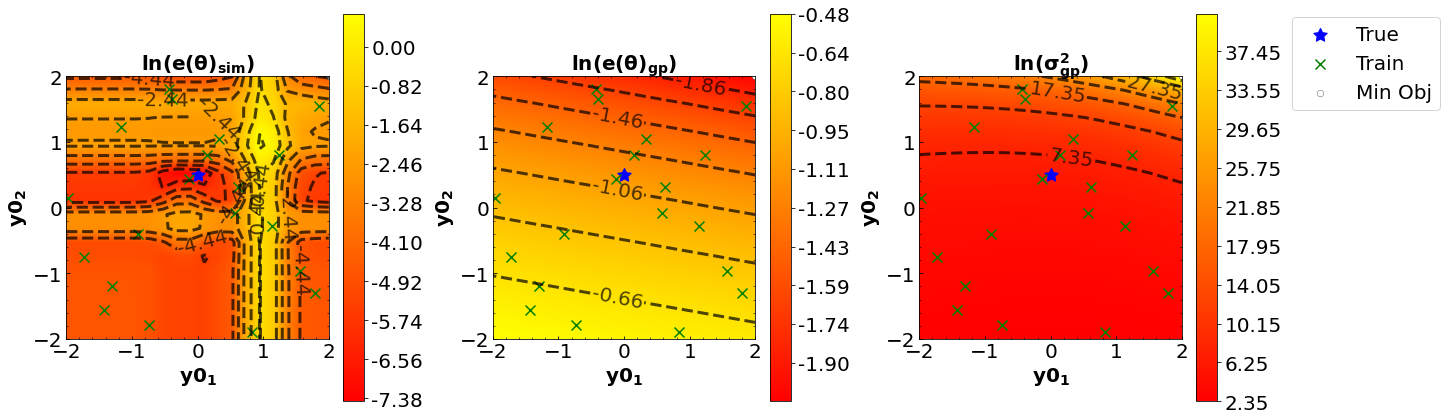

IndexError: list index out of range

In [12]:
# from sklearn.exceptions import InconsistentVersionWarning
# warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)

#Make heat maps
#Loop over best run/iter for each method
for i in range(len(meth_name_str_list)): 
    
    simulator, exp_data, min_Mul, train_data, fit_gp_model, scaler, method = run_experiment(cs_name_val, meth_name_str_list[i], param_name_str, normalize, 
                                                   noise_mean, noise_std, sep_fact, retrain_GP, reoptimize_obj, 
                                                   seed, num_x_data, num_theta_data_scl, num_theta_data_val, 
                                                   gen_meth_theta_val, val_data, val_sse_data, gen_heat_map_data, gen_meth_x)
    heat_map_data_dict, n_points = make_hm_2(simulator, exp_data, sep_fact, seed)

    sample_key = list(heat_map_data_dict.keys())[0]
    dim_theta = np.array(heat_map_data_dict[sample_key].theta_vals[0]).reshape(-1, 1)
    dim_theta = len(dim_theta)
    dim_list = np.linspace(0, dim_theta-1, dim_theta)
    method_name = Method_name_enum(meth_name_str_list[i]).name

    #Get Number of pairs
    pairs = len((list(combinations(dim_list, 2))))
    
    #Set the save path as the job path
    if save_fig == True:
        if not os.path.isdir("Test_log_Muller"):
            os.makedirs(dir_name)
        save_path = dir_name + "/" + method_name
    else:
        save_path = None

    #For each pair
    for pair in range(pairs):
        analysis_list = analyze_hm_2(pair, heat_map_data_dict, scaler, fit_gp_model, method, n_points, simulator, train_data,
                                 min_Mul, sep_fact, seed, log_data)
        sim_sse_var_ei, test_mesh, theta_true, theta_opt, train_theta, param_names, idcs_to_plot = analysis_list
        sse_sim, sse_mean, sse_var, = sim_sse_var_ei
        title = "Heat Map Pair " + "-".join(map(str, param_names))
        title = None

        z = [sse_sim, sse_mean, sse_var]
        if log_data == True:
            z_titles = ["ln("+ r"$\mathbf{e(\theta)_{sim}}$" + ")", 
                        "ln("+ r"$\mathbf{e(\theta)_{gp}}$" + ")", 
                        "ln("+ r"$\mathbf{\sigma^2_{gp}}$" + ")"]
        else:
            z_titles = [r"$\mathbf{e(\theta)_{sim}}$" + ")", 
                        r"$\mathbf{e(\theta)_{gp}}$" + ")", 
                        r"$\mathbf{\sigma^2_{gp}}$" + ")"]
        z_save_names = ["sse_sim", "sse_gp_mean", "sse_var"]
        path_end = '-'.join(z_save_names) 
        levels = [100,100,100]

        plot_heat_maps(test_mesh, theta_true, theta_opt, None, train_theta, param_names, levels, idcs_to_plot, 
                    z, z_titles, xbins, ybins, zbins, title, title_fontsize, other_fontsize, cmap, save_path, z_save_names)
        
    #Create mp4/gif files from pngs
    #Initialize filename list
    filenames = []
    
    #Add all Heat map data files to list
    #Create directory to store Heat Map Movies
    dir_name = "Test_log_Muller"
    heat_map_files = glob.glob("Test_log_Muller/*.png")
    filenames += heat_map_files
  
    if save_fig is True:
        if not os.path.isdir(dir_name):
            os.makedirs(dir_name)
        gif_path = dir_name + path_end + ".mp4"

        #Create .mp4 file
        with imageio.get_writer(gif_path, mode='I', fps=0.3) as writer: #Note. For gif use duration instead of fps
            #For each file
            for filename in filenames: 
                #Get image
                image = imageio.imread(filename, pilmode = "RGBA")
                #Get the correct shape for the pngs based on the 1st file
                if filename == filenames[0]: 
                    shape = image.shape
                    #Force image to have XY dims divisible by 16
                    new_shape = (np.ceil(shape[0] / 16) * 16, np.ceil(shape[1] / 16) * 16, shape[2])
                #If item shapes not the same force them to be the same. Fixes issues where pixels are off
                if image.shape is not shape: 
                    image = resize(image, (new_shape))
                #Add file to movie as a uint8 type and multiply array by 255 to get correct coloring
                writer.append_data((image*255).astype(np.uint8)) 
